In [ ]:
# ==========================================
# SCRIPT KOREKSI BIAS: GENETIC ALGORITHM (GA)
# ==========================================
# Penulis: Jariyan Arifudin
# Metode: Non-Linear Power Law Correction (Optimized by GA)
# Rumus: P_corr = a * (P_sat ^ b)
# ==========================================

# 1. INSTALL LIBRARY KHUSUS GA
!pip install rasterio geopandas shapely matplotlib scikit-learn pandas numpy seaborn tqdm folium pygad

import os
import glob
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import pygad  # <--- Library Genetic Algorithm
from google.colab import drive
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
# ==========================================
# BAGIAN 1: SETUP & KONFIGURASI
# ==========================================

# Mount Google Drive
drive.mount('/content/drive')

# --- DIREKTORI DATA ---
BASE_DIR = '/content/drive/My Drive/Colab Notebooks/Skripsi/'
CHIRPS_DIR = os.path.join(BASE_DIR, 'CHIRPS v3/')
ADMIN_PATH = os.path.join(BASE_DIR, 'Batas Adm Jambi/Adm_Jambi_Prov.shp')
CSV_DIR = os.path.join(BASE_DIR, 'Data Stasiun BWS Sumatera VI/')

# Output Directory Utama
output_dir = os.path.join(CHIRPS_DIR, 'bias_corrected_ga')
os.makedirs(output_dir, exist_ok=True)

# Output Directory Khusus Raster 2009-2020
raster_output_dir = os.path.join(output_dir, 'raster_2009_2020')
os.makedirs(raster_output_dir, exist_ok=True)

# Rentang wilayah
bbox = box(100.75, -2.75, 104.75, -0.5)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs='EPSG:4326')

# --- DAFTAR STASIUN ---
bias_stations = [
    "Koto Limau Sering", "Semurup", "Sipin", "Siulak Deras",
    "Dendang", "Pulau Tengah", "Tamiai"
]

validation_stations = [
    "Bukit Bulan",
    "Muara Tembesi",
    "Rantau Pandan",
    "Sungai Manau",
    "Tanjung Genting",
    "Muaro Imat",
    "Sungai Bengkal"
]

station_coords = {
    "Koto Limau Sering": (101.366300, -2.063383),
    "Semurup": (101.378350, -2.001750),
    "Sipin": (103.596750, -1.610600),
    "Siulak Deras": (101.297850, -1.936050),
    "Dendang": (103.948100, -1.190800),
    "Pulau Tengah": (101.463533, -2.169750),
    "Tamiai": (101.643800, -2.186933),
    "Batang Asai": (102.285631, -2.492758),
    "Biuku Tanjung": (102.201683, -2.123467),
    "Bukit Bulan": (102.639417, -2.517517),
    "Hiang": (101.477800, -2.074217),
    "Jujuhan": (101.766217, -1.328300),
    "Kersik Tuo": (101.282533, -1.779867),
    "Pulau Musang": (102.100717, -1.157717),
    "Mess Bungo": (102.330650, -1.494717),
    "Muara Jernih": (102.166800, -1.950067),
    "Muara Tembesi": (103.127017, -1.719333),
    "Pulau Lintang": (102.592700, -2.280883),
    "Rantau Pandan": (101.968817, -1.621217),
    "Rimbo Bujang": (102.088833, -1.319517),
    "Senamat": (102.330650, -1.643583),
    "Suak Kandis": (104.053117, -1.374000),
    "Sungai Manau": (101.983400, -2.114817),
    "Tanjung Genting": (103.161200, -1.938300),
    "Durian Luncuk": (102.995683, -1.880150),
    "Gapura Suci": (102.285383, -1.699950),
    "Lempur": (101.627683, -2.248867),
    "Muaro Imat": (101.719850, -2.225333),
    "Pamenang": (102.512817, -2.112200),
    "Pasir Putih": (103.643200, -1.622550),
    "Pauh": (102.820633, -2.133417),
    "Sungai Bengkal": (102.723933, -1.550633),
    "Singkut": (102.713633, -2.506200)
}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==========================================
# BAGIAN 2: FUNGSI UTILITAS
# ==========================================

def clip_raster_to_bbox(input_path, bbox_geom):
    with rasterio.open(input_path) as src:
        out_image, out_transform = mask(src, bbox_geom.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    return out_image[0], out_meta

def extract_chirps_at_point(raster, transform, lon, lat):
    row, col = rasterio.transform.rowcol(transform, lon, lat)
    try:
        val = raster[row, col]
        return val if val != -9999 else np.nan
    except IndexError:
        return np.nan

def load_station_csv(csv_dir):
    bulan_mapping = {'Januari': '01', 'Februari': '02', 'Maret': '03', 'April': '04',
                     'Mei': '05', 'Juni': '06', 'Juli': '07', 'Agustus': '08',
                     'September': '09', 'Oktober': '10', 'November': '11', 'Desember': '12'}
    station_data = {}
    csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))

    if not csv_files:
        print("[ERROR] Tidak ada file CSV ditemukan!")
        return {}

    for csv_file in csv_files:
        nama = os.path.basename(csv_file).replace('.csv', '')
        try:
            df = pd.read_csv(csv_file, index_col=0)
            df.replace("-", np.nan, inplace=True)
            df = df.apply(pd.to_numeric, errors='coerce')
            df = df.stack().reset_index()
            df.columns = ['Bulan', 'Tahun', 'CurahHujan']
            df['BulanAngka'] = df['Bulan'].map(bulan_mapping)
            df['Tanggal'] = pd.to_datetime(df['Tahun'].astype(str) + "-" + df['BulanAngka'] + "-01")
            df.set_index('Tanggal', inplace=True)
            station_data[nama] = df[['CurahHujan']].sort_index()
        except:
            pass
    return station_data

In [ ]:
# ==========================================
# BAGIAN 3: OPTIMASI GENETIC ALGORITHM
# ==========================================

print("--- Memuat Data untuk Training GA ---")
station_data = load_station_csv(CSV_DIR)
chirps_files = sorted(glob.glob(os.path.join(CHIRPS_DIR, 'chirps-v3.0.*.tif')))

# 1. KUMPULKAN DATA TRAINING (Obs vs Sat)
X_train_list = []
y_train_list = []

print("Mengumpulkan dataset training dari stasiun kalibrasi...")
# Sampling cepat (tanpa simpan raster)
for file_path in tqdm(chirps_files, desc="Sampling Data"):
    try:
        filename = os.path.basename(file_path)
        parts = filename.split('.')
        date = pd.to_datetime(f"{parts[2]}-{parts[3]}-01")
    except:
        continue

    # Baca raster windowed
    with rasterio.open(file_path) as src:
        out_image, out_transform = mask(src, bbox_gdf.geometry, crop=True)
        raster_data = out_image[0]

    for stasiun in bias_stations:
        if stasiun in station_data:
            try:
                obs_val = station_data[stasiun].reindex([date])['CurahHujan'].values[0]
                lon, lat = station_coords[stasiun]
                sat_val = extract_chirps_at_point(raster_data, out_transform, lon, lat)

                if not np.isnan(obs_val) and not np.isnan(sat_val) and sat_val >= 0:
                    X_train_list.append(sat_val)
                    y_train_list.append(obs_val)
            except:
                continue

X_train = np.array(X_train_list)
y_train = np.array(y_train_list)

print(f"\nJumlah sampel training GA: {len(X_train)} pasang data")

# 2. DEFINISI FUNGSI FITNESS GA
# Solusi (solution) berisi 2 gen: [a, b] untuk rumus a * Sat ^ b
def fitness_func(ga_instance, solution, solution_idx):
    a = solution[0]
    b = solution[1]

    # Prediksi menggunakan parameter a dan b
    pred = a * np.power(X_train, b)

    # Hitung RMSE
    mse = np.mean((y_train - pred)**2)
    rmse = np.sqrt(mse)

    # Fitness GA harus dimaksimalkan (1/RMSE)
    fitness = 1.0 / (rmse + 0.0001)
    return fitness

# 3. KONFIGURASI DAN JALANKAN GA
print("\n--- Menjalankan Optimasi Algoritma Genetika ---")
ga_instance = pygad.GA(num_generations=30,      # Jumlah generasi (iterasi evolusi)
                       num_parents_mating=4,    # Jumlah induk
                       fitness_func=fitness_func,
                       sol_per_pop=10,          # Ukuran populasi
                       num_genes=2,             # Mencari 2 variabel (a, b)
                       gene_type=float,
                       init_range_low=0.1,      # Batas bawah pencarian acak awal
                       init_range_high=2.0,     # Batas atas pencarian acak awal
                       mutation_percent_genes=10) # Probabilitas mutasi

ga_instance.run()

# 4. AMBIL HASIL TERBAIK
solution, solution_fitness, solution_idx = ga_instance.best_solution()
best_a = solution[0]
best_b = solution[1]
best_rmse = 1.0 / solution_fitness

print(f"\n=========================================")
print(f"HASIL OPTIMASI GA (POWER LAW MODEL):")
print(f"Persamaan: P_corr = a * (P_sat ^ b)")
print(f"Nilai a (Scale)    : {best_a:.4f}")
print(f"Nilai b (Shape)    : {best_b:.4f}")
print(f"RMSE Training      : {best_rmse:.4f}")
print(f"=========================================\n")

--- Memuat Data untuk Training GA ---
Mengumpulkan dataset training dari stasiun kalibrasi...


Sampling Data: 100%|██████████| 144/144 [00:30<00:00,  4.74it/s]


Jumlah sampel training GA: 1008 pasang data

--- Menjalankan Optimasi Algoritma Genetika ---

HASIL OPTIMASI GA (POWER LAW MODEL):
Persamaan: P_corr = a * (P_sat ^ b)
Nilai a (Scale)    : 2.5483
Nilai b (Shape)    : 0.7892
RMSE Training      : 98.0089



In [ ]:
# ==========================================
# BAGIAN 4: MENERAPKAN KOREKSI & VALIDASI & SIMPAN TIFF 2009-2020
# ==========================================

print("[TAHAP PENERAPAN] Mengoreksi Raster & Validasi Independen...")
validasi_df = pd.DataFrame()

for file_path in tqdm(chirps_files, desc="Processing Raster"):
    filename = os.path.basename(file_path)
    try:
        parts = filename.split('.')
        date = pd.to_datetime(f"{parts[2]}-{parts[3]}-01")
    except:
        continue

    # 1. Baca Raster
    raster, meta = clip_raster_to_bbox(file_path, bbox_gdf)

    # 2. TERAPKAN RUMUS GA (Non-Linear)
    # P_corr = a * P_sat ^ b
    corrected_raster = best_a * np.power(raster, best_b)
    corrected_raster = np.maximum(corrected_raster, 0) # Safety check

    # --- [UPDATE] SIMPAN RASTER TIFF 2009-2020 DENGAN FORMAT BARU ---
    if 2009 <= date.year <= 2020:
        # Update metadata agar sesuai tipe data float
        out_meta = meta.copy()
        out_meta.update(dtype='float32')

        # Format Nama: chirps-v3.0.{Tahun}.{Bulan}.ga_corrected.tif
        outname = f"chirps-v3.0.{date.year:04d}.{date.month:02d}.ga_corrected.tif"
        outpath = os.path.join(raster_output_dir, outname)

        # Tulis file
        with rasterio.open(outpath, "w", **out_meta) as dest:
            dest.write(corrected_raster.astype('float32'), 1)
    # ----------------------------------------------------------------

    # 3. Validasi
    for stasiun in validation_stations:
        obs_val = np.nan
        raw_val = np.nan
        corr_val = np.nan

        if stasiun in station_data:
            try:
                val = station_data[stasiun].reindex([date])['CurahHujan'].values[0]
                if not np.isnan(val): obs_val = val
            except: pass

        if stasiun in station_coords:
            lon, lat = station_coords[stasiun]
            raw_val = extract_chirps_at_point(raster, meta['transform'], lon, lat)
            corr_val = extract_chirps_at_point(corrected_raster, meta['transform'], lon, lat)

        if not (np.isnan(obs_val) and np.isnan(raw_val)):
            entry = pd.DataFrame([{
                "Stasiun": stasiun,
                "Tanggal": date,
                "Observed": obs_val,
                "Raw": raw_val,
                "Corrected": corr_val,
                "Param_a": best_a,
                "Param_b": best_b
            }])
            validasi_df = pd.concat([validasi_df, entry], ignore_index=True)

# Simpan Data Validasi
validasi_df.sort_values(['Stasiun', 'Tanggal'], inplace=True)
validasi_df.to_csv(os.path.join(output_dir, 'validasi_ga_raw.csv'), index=False)

print(f"\n[INFO] File Raster 2009-2020 telah disimpan di: {raster_output_dir}")

[TAHAP PENERAPAN] Mengoreksi Raster & Validasi Independen...


Processing Raster: 100%|██████████| 144/144 [00:34<00:00,  4.15it/s]


[INFO] File Raster 2009-2020 telah disimpan di: /content/drive/My Drive/Colab Notebooks/Skripsi/CHIRPS v3/bias_corrected_ga/raster_2009_2020


In [ ]:
# ==========================================
# BAGIAN 5: HITUNG METRIK & VISUALISASI
# ==========================================
print("\n--- Menghitung Indikator Statistik ---")
final_metrics = []

for stasiun in validation_stations:
    subset = validasi_df[validasi_df['Stasiun'] == stasiun]
    stats = {
        "Stasiun": stasiun,
        "NSE_Raw": np.nan, "NSE_Corrected": np.nan,
        "R_Raw": np.nan, "R_Corrected": np.nan,
        "RSR_Raw": np.nan, "RSR_Corrected": np.nan
    }

    if not subset.empty:
        obs = subset["Observed"].values
        raw = subset["Raw"].values
        corr = subset["Corrected"].values
        mask_raw = ~np.isnan(obs) & ~np.isnan(raw)
        mask_corr = ~np.isnan(obs) & ~np.isnan(corr)

        def calc_stats(o, p):
            if len(o) < 2: return np.nan, np.nan, np.nan
            r_val, _ = pearsonr(o, p)
            num = np.sum((o - p)**2)
            den = np.sum((o - np.mean(o))**2)
            nse = 1 - (num / den) if den != 0 else np.nan
            rmse = np.sqrt(mean_squared_error(o, p))
            stdev = np.std(o)
            rsr = rmse / stdev if stdev != 0 else np.nan
            return nse, r_val, rsr

        stats["NSE_Raw"], stats["R_Raw"], stats["RSR_Raw"] = calc_stats(obs[mask_raw], raw[mask_raw])
        stats["NSE_Corrected"], stats["R_Corrected"], stats["RSR_Corrected"] = calc_stats(obs[mask_corr], corr[mask_corr])

    final_metrics.append(stats)

summary = pd.DataFrame(final_metrics)
print(summary.head().to_string())
summary.to_csv(os.path.join(output_dir, 'Hasil_Validasi_GA_NSE_R_RSR.csv'), index=False)


--- Menghitung Indikator Statistik ---
           Stasiun   NSE_Raw  NSE_Corrected     R_Raw  R_Corrected   RSR_Raw  RSR_Corrected
0      Bukit Bulan  0.052189       0.237366  0.491433     0.491245  0.973556       0.873289
1    Muara Tembesi -5.723833      -1.710641  0.542688     0.549439  2.593036       1.646402
2    Rantau Pandan  0.106813       0.278091  0.564325     0.557992  0.945086       0.849652
3     Sungai Manau -0.350546       0.074126  0.368643     0.365374  1.162130       0.962223
4  Tanjung Genting -0.706896       0.045501  0.407449     0.409506  1.306482       0.976985


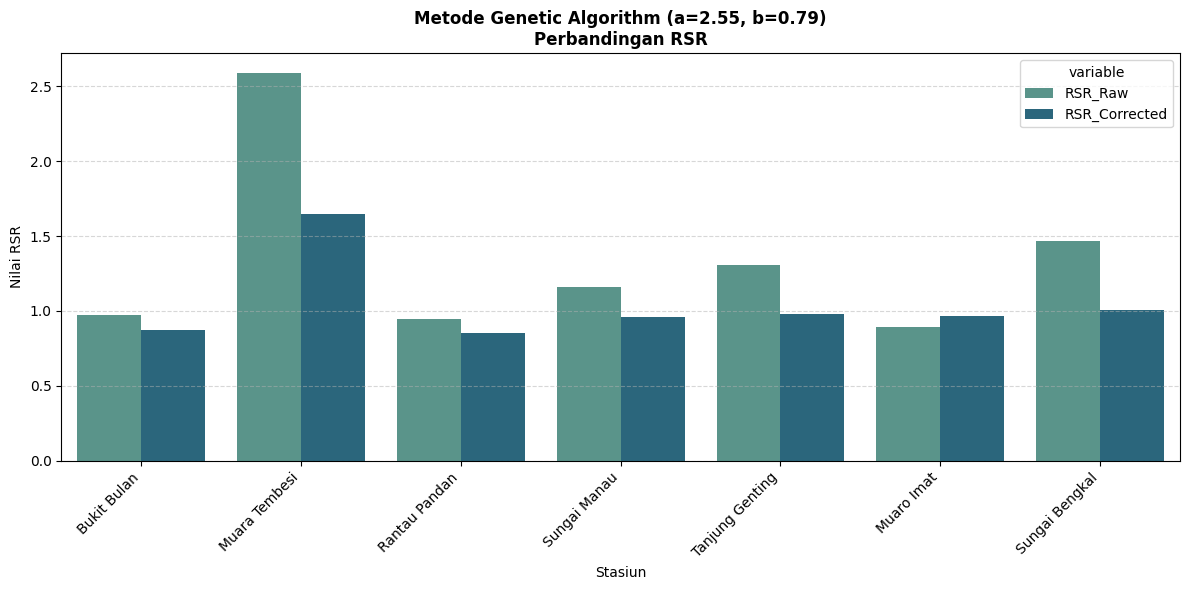

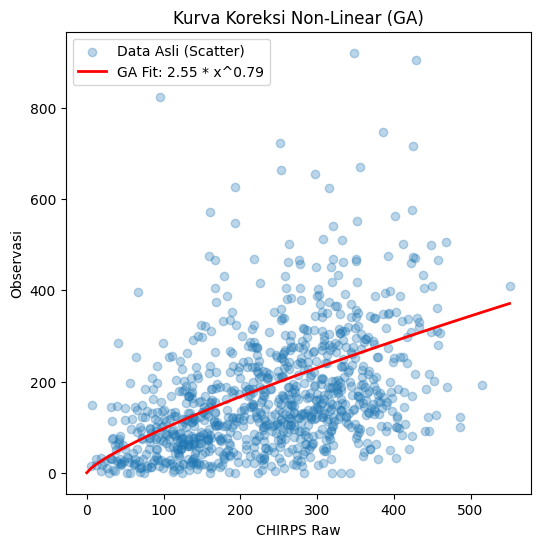

In [ ]:
# Visualisasi
plt.figure(figsize=(12, 6))
plot_data = summary.melt(id_vars='Stasiun', value_vars=['RSR_Raw', 'RSR_Corrected'])
sns.barplot(data=plot_data, x='Stasiun', y='value', hue='variable', palette='crest')
plt.title(f'Metode Genetic Algorithm (a={best_a:.2f}, b={best_b:.2f})\nPerbandingan RSR', fontweight='bold')
plt.ylabel('Nilai RSR')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))

# Plot kurva fitting
x_dummy = np.linspace(0, validasi_df['Raw'].max(), 100)
y_dummy = best_a * np.power(x_dummy, best_b)
plt.scatter(validasi_df['Raw'], validasi_df['Observed'], alpha=0.3, label='Data Asli (Scatter)')
plt.plot(x_dummy, y_dummy, 'r-', linewidth=2, label=f'GA Fit: {best_a:.2f} * x^{best_b:.2f}')
plt.xlabel('CHIRPS Raw')
plt.ylabel('Observasi')
plt.legend()
plt.title('Kurva Koreksi Non-Linear (GA)')
plt.show()